In [24]:
from pybaseball import statcast, pitching_stats_range, statcast_pitcher, pitching_stats
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import re
import unicodedata
import os
from xgboost import XGBRegressor, plot_importance
from ml_preds import fix_escaped_unicode,normalize_name
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor, plot_importance
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [7]:
date = datetime.today().strftime('%Y-%m-%d')
df_2023 = pitching_stats_range('2023-04-01', '2023-10-01')
df_2023['year'] = 2023
df_2024 = pitching_stats_range('2024-04-01', '2024-10-01')
df_2024['year'] = 2024
df_2025 = pitching_stats_range('2025-04-01', f'{date}') 
df_2025['year'] = 2025

In [17]:
df_base = pd.concat([df_2023, df_2024, df_2025], ignore_index=True)
df_base['Name'] = df_base['Name'].apply(fix_escaped_unicode)
df_base['Name'] = df_base['Name'].apply(normalize_name)
#print(df_base.columns)

In [18]:
df_merge = pd.read_csv('data/pitcher_stats/pitcher_stats.csv')
df_merge[['last_name', 'first_name']] = df_merge["last_name, first_name"].str.split(",", expand=True)
df_merge['Name'] = (df_merge['first_name'].str.strip() + ' ' + df_merge['last_name'].str.strip()).apply(normalize_name)
print(df_merge.columns)

Index(['last_name, first_name', 'player_id', 'year', 'pa', 'k_percent',
       'bb_percent', 'woba', 'xwoba', 'sweet_spot_percent',
       'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed',
       'avg_hyper_speed', 'whiff_percent', 'swing_percent', 'last_name',
       'first_name', 'Name'],
      dtype='object')


In [14]:
print(df_merge.dtypes)

last_name, first_name     object
player_id                  int64
year                       int64
pa                         int64
k_percent                float64
bb_percent               float64
woba                     float64
xwoba                    float64
sweet_spot_percent       float64
barrel_batted_rate       float64
hard_hit_percent         float64
avg_best_speed           float64
avg_hyper_speed          float64
whiff_percent            float64
swing_percent            float64
last_name                 object
first_name                object
Name                      object
dtype: object


In [21]:
df_merged = pd.merge(df_base, df_merge, on=['Name', 'year'], how='inner')
df_merged = df_merged.drop(columns=['first_name', 'last_name', 'last_name, first_name'])
print(df_merged.columns)

Index(['Name', 'Age', '#days', 'Lev', 'Tm', 'G', 'GS', 'W', 'L', 'SV', 'IP',
       'H', 'R', 'ER', 'BB', 'SO', 'HR', 'HBP', 'ERA', 'AB', '2B', '3B', 'IBB',
       'GDP', 'SF', 'SB', 'CS', 'PO', 'BF', 'Pit', 'Str', 'StL', 'StS',
       'GB/FB', 'LD', 'PU', 'WHIP', 'BAbip', 'SO9', 'SO/W', 'mlbID', 'year',
       'player_id', 'pa', 'k_percent', 'bb_percent', 'woba', 'xwoba',
       'sweet_spot_percent', 'barrel_batted_rate', 'hard_hit_percent',
       'avg_best_speed', 'avg_hyper_speed', 'whiff_percent', 'swing_percent'],
      dtype='object')


In [22]:
df_merged.to_csv('data/pitcher_stats/merged_pitcher_stats.csv', index=False)

In [34]:
df = pd.read_csv('data/pitcher_stats/merged_pitcher_stats.csv')

df['SO_per_game'] = df['SO'] / df['G'].replace(0, np.nan)
df['SO_per_IP'] = df['SO'] / df['IP'].replace(0, np.nan)
df['K_BB_ratio'] = df['SO'] / df['BB'].replace(0, np.nan)

drop_cols = ['Name', 'Lev', 'Tm', 'mlbID', 'player_id', 'SV']
df = df.drop(columns=drop_cols)

df = df.replace([np.inf, -np.inf], np.nan).dropna()

target = 'SO_per_game'
features = df.columns.drop(['year', target])

train_df = df[df['year'] < 2025]
test_df = df[df['year'] == 2025]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

model = XGBRegressor(n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Full Model:")
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

Full Model:
R²: 0.7902008559836804
MSE: 0.3284219994837939



Permutation Importance:
k_percent: 0.7093
SO_per_IP: 0.0813
xwoba: 0.0359
W: 0.0115
G: 0.0110
SO9: 0.0106
SO: 0.0092
ERA: 0.0040
StS: 0.0022
woba: 0.0020
Str: 0.0018
swing_percent: 0.0017
L: 0.0012
GB/FB: 0.0010
SB: 0.0006
R: 0.0005
whiff_percent: 0.0005
3B: 0.0004
PU: 0.0004
WHIP: 0.0004
H: 0.0003
GDP: 0.0001
BAbip: 0.0001
BB: 0.0001
StL: 0.0001
IBB: 0.0001
K_BB_ratio: 0.0000
SF: 0.0000
IP: 0.0000
AB: 0.0000
GS: 0.0000
#days: 0.0000
BF: 0.0000
SO/W: 0.0000
Pit: 0.0000
pa: 0.0000
hard_hit_percent: -0.0000
CS: -0.0000
PO: -0.0000
avg_hyper_speed: -0.0000
2B: -0.0000
HR: -0.0001
ER: -0.0002
HBP: -0.0002
bb_percent: -0.0006
sweet_spot_percent: -0.0006
barrel_batted_rate: -0.0008
avg_best_speed: -0.0013
Age: -0.0021
LD: -0.0042


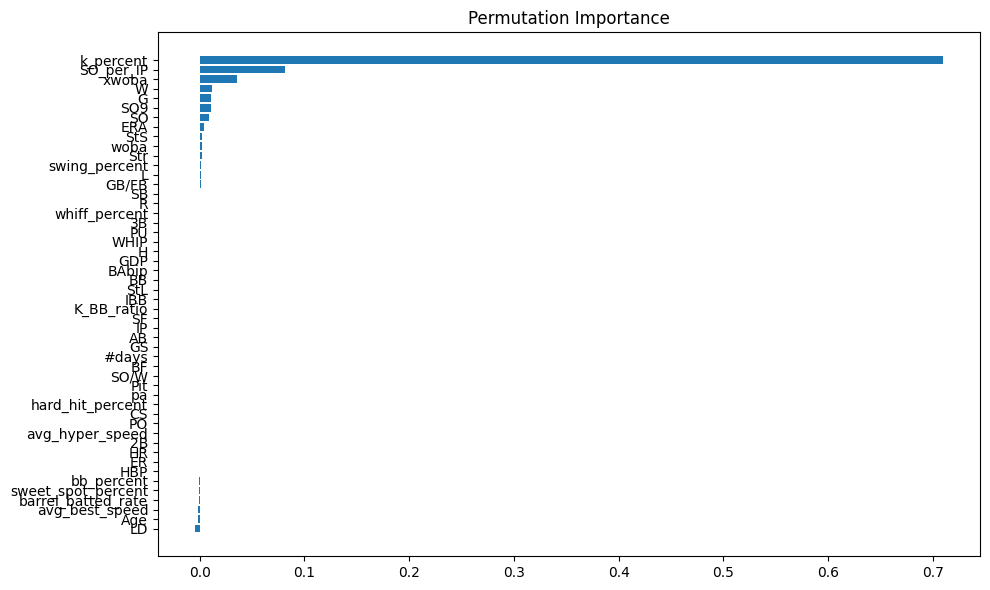

In [37]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

print("\nPermutation Importance:")
for i in sorted_idx:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.gca().invert_yaxis()
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()


In [36]:
from sklearn.ensemble import RandomForestRegressor
rfe_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(rfe_model, n_features_to_select=5)
rfe.fit(X_train, y_train)

top_features = X_train.columns[rfe.support_]
print(f"Top Features from RFE: {top_features.tolist()}")

# Retrain using only top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

model_top = XGBRegressor(n_estimators=100, learning_rate=0.05)
model_top.fit(X_train_top, y_train)
y_pred_top = model_top.predict(X_test_top)

print("\nModel with Top RFE Features:")
print("R²:", r2_score(y_test, y_pred_top))
print("MSE:", mean_squared_error(y_test, y_pred_top))


Top Features from RFE: ['G', 'SO', 'k_percent', 'woba', 'SO_per_IP']

Model with Top RFE Features:
R²: 0.8037621895067066
MSE: 0.30719293159516414
